In [1]:
from psycopg2 import connect, extras
import numpy as np
import datetime
import pandas as pd
import glob,os
from matplotlib import pyplot as plt

In [2]:
'''Need to clone chris m's visual behavior code
    located here: https://github.com/mochic/visual_behavior_analysis.git
    Then change path below to point to visual_behavior repo
'''

%cd "C:\Users\svc_ccg\Documents\GitHub\visual_behavior_analysis"
from visual_behavior.translator.foraging2 import data_to_change_detection_core
from visual_behavior.translator.core import create_extended_dataframe

C:\Users\svc_ccg\Documents\GitHub\visual_behavior_analysis


**setup sql connection/cursor to get data from lims**

In [3]:
con = connect(
    dbname='lims2',
    user='limsreader',
    host='limsdb2',
    password='limsro',
    port=5432,
)

con.set_session(
    readonly=True, 
    autocommit=True,
)

cursor = con.cursor(
    cursor_factory=extras.RealDictCursor,
)

In [60]:
def getLimsID(mouse_id):
    query_template = '''
    SELECT * 
    FROM donors d
    WHERE d.external_donor_name = '{}'
    '''

    cursor.execute(query_template.format(mouse_id))
    lims_id = cursor.fetchone()['id']
    return lims_id

def getBehaviorSessionsFromLimsID(lims_id):
    query_template = '''
    SELECT *
    FROM behavior_sessions bs
    WHERE bs.donor_id = {}
    '''

    cursor.execute(query_template.format(lims_id))
    behavior_sessions = pd.DataFrame(cursor.fetchall())
    return behavior_sessions

def getBehaviorSessionsForMouse(mouse_id):
    lims_id = getLimsID(mouse_id)
    return getBehaviorSessionsFromLimsID(lims_id)

def getPicklePath(storage_directory):
    if storage_directory[1] != '/':
        storage_directory = '/' + storage_directory
    pp = glob.glob(os.path.join(storage_directory, '*.pkl'))
    if len(pp)>0:
        return pp[0]
    else:
        return None
    
def getTrialsDF(pklpath):
    p = pd.read_pickle(pklpath)
    if 'behavior' in p['items']:
        core_data = data_to_change_detection_core(p)
        trials = create_extended_dataframe(
                trials=core_data['trials'],
                metadata=core_data['metadata'],
                licks=core_data['licks'],
                time=core_data['time'])
    else:
        print('Found non-behavior pickle file: ' + pklpath)
        trials = pd.DataFrame.from_dict({'stage':[None]})
    return trials
    

**pull behavior sessions for a given mouse into pandas dataframe**

In [12]:
mouse_id = '477120'
beh_sessions = getBehaviorSessionsForMouse(mouse_id)

#add common rig name
beh_sessions['rig'] = beh_sessions.apply(lambda row: 
        pd.read_sql('select * from equipment where id = {}'.format(row['equipment_id']), con)['name'], axis=1)

#add pkl file paths
beh_sessions['pklfile'] = beh_sessions.apply(lambda row: 
        getPicklePath(row['storage_directory']), axis=1)


In [103]:
#pick out dates to analyze: it takes a bit of time to pull this data from the network, so limiting your
#dates is helpful when possible. Right now I'm pulling from 'daysBeforeHandoff' to end
daysBeforeHandoff = 14

handoff = beh_sessions[beh_sessions['rig'].str.contains('NP')].iloc[-1]['created_at']
endDate = beh_sessions[beh_sessions['rig'].str.contains('NP')].iloc[0]['created_at']
startDate = handoff - pd.DateOffset(days=daysBeforeHandoff)

toAnalyze = beh_sessions[(beh_sessions['created_at']>=startDate)&(beh_sessions['created_at']<endDate)]

In [104]:
toAnalyze['trials'] = toAnalyze.apply(lambda row: getTrialsDF(row['pklfile']), axis=1) #this trials object has all the info you need about the session
toAnalyze['stage'] = toAnalyze.apply(lambda row: row['trials']['stage'][0], axis=1) #add the training stage to the dataframe
toAnalyze = toAnalyze.loc[toAnalyze['stage'].notnull()] #filter out the passive pickle files that get added during recordings
toAnalyze['session_datetime'] = toAnalyze.apply(lambda row: row['trials']['startdatetime'][0], axis=1)

Found non-behavior pickle file: //allen/programs/braintv/production/visualbehavior/prod0/specimen_909823930/behavior_session_978213743\5aa390345d28425e97cf616721afa3cf.pkl
Found non-behavior pickle file: //allen/programs/braintv/production/visualbehavior/prod0/specimen_909823930/behavior_session_978213743\5aa390345d28425e97cf616721afa3cf.pkl


c:\anaconda2\envs\lims\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\anaconda2\envs\lims\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


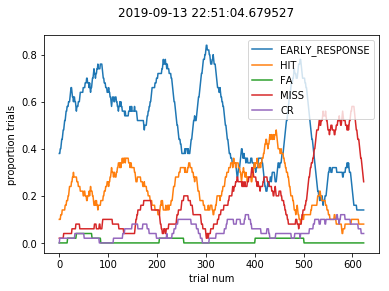

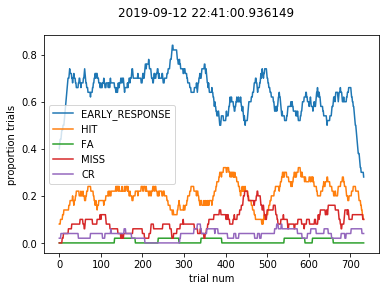

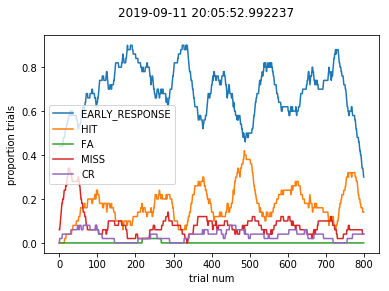

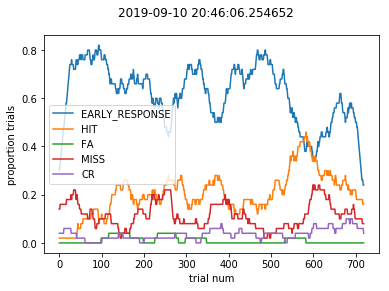

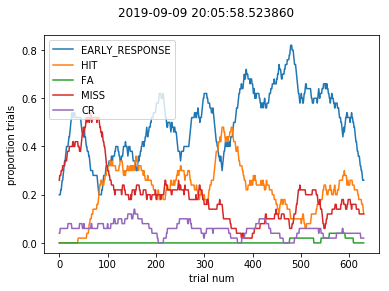

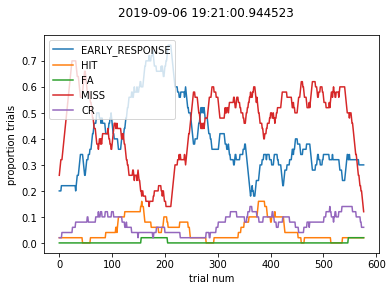

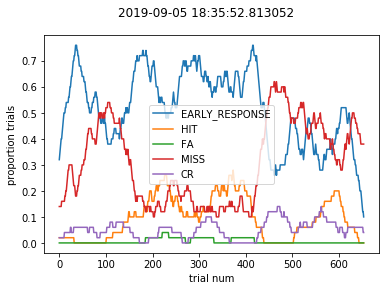

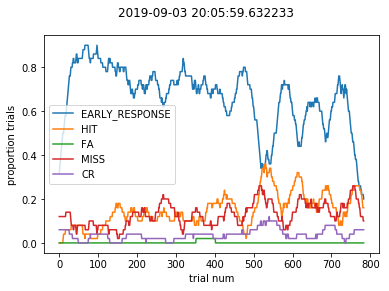

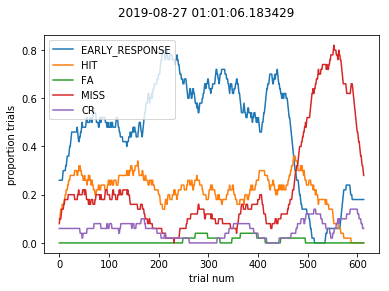

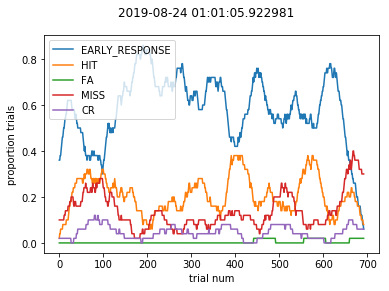

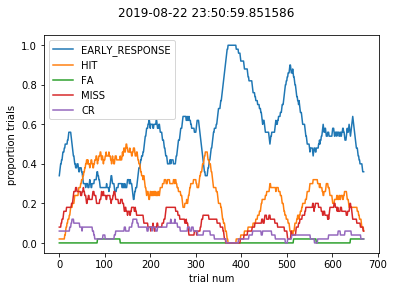

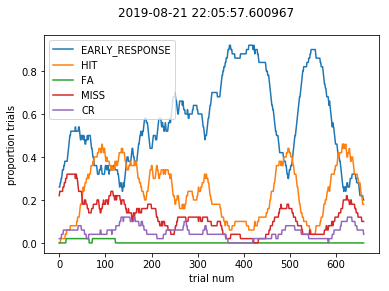

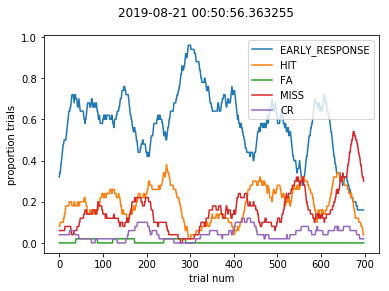

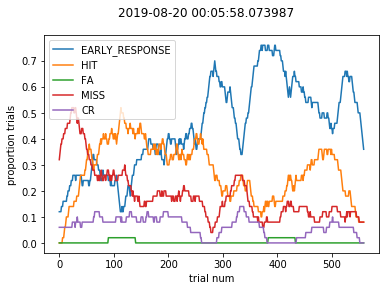

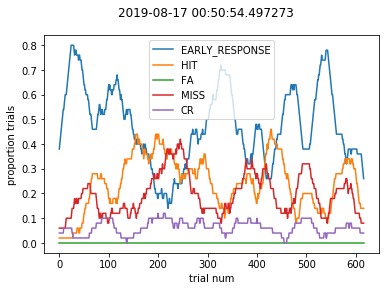

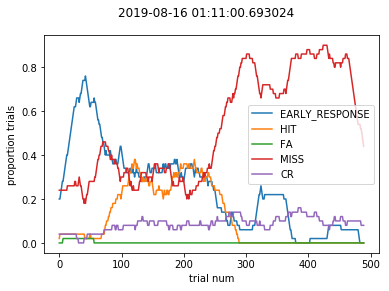

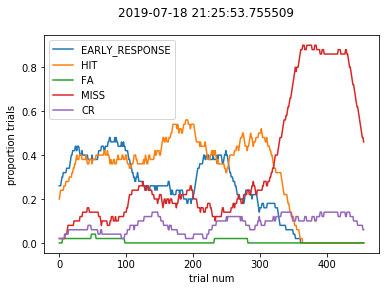

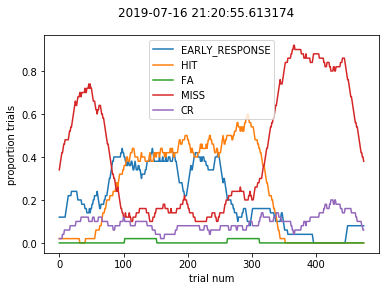

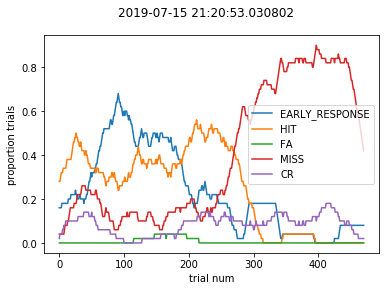

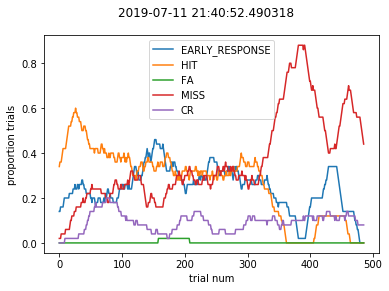

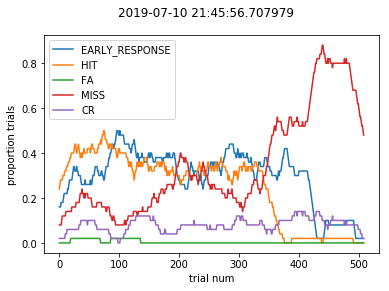

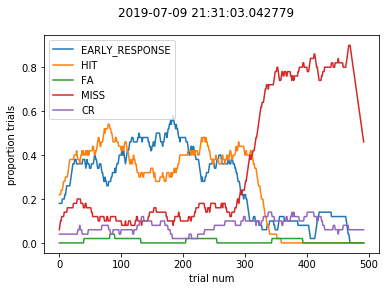

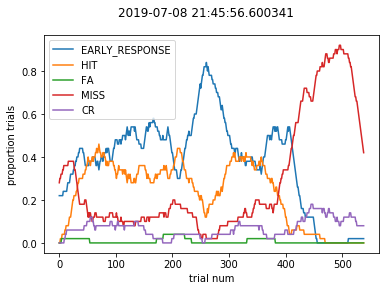

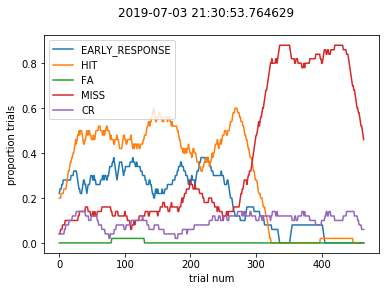

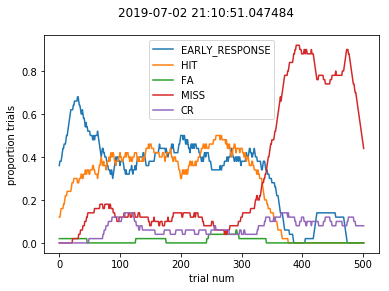

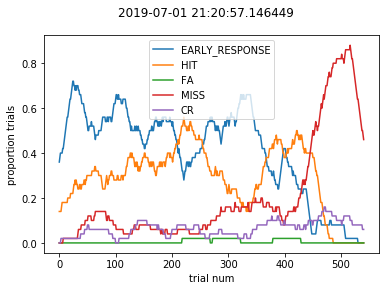

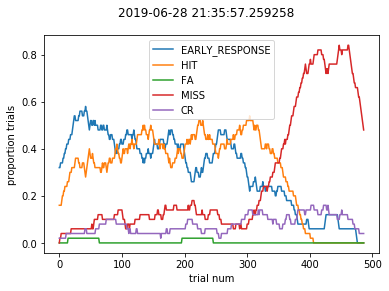

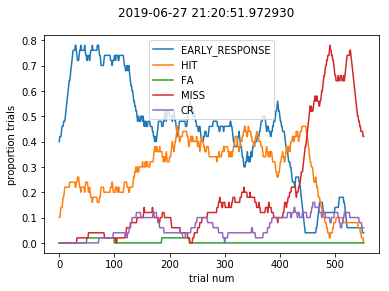

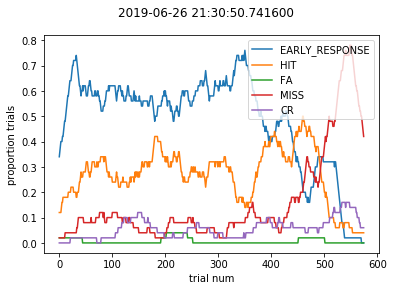

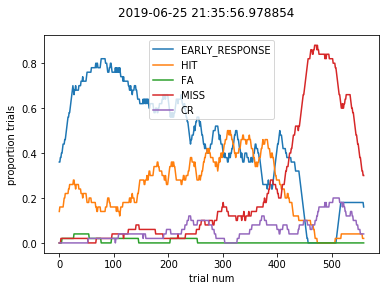

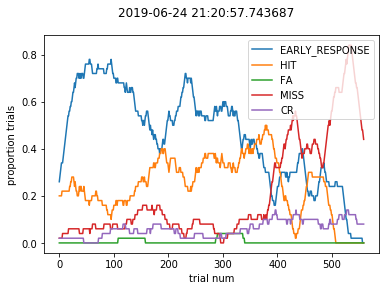

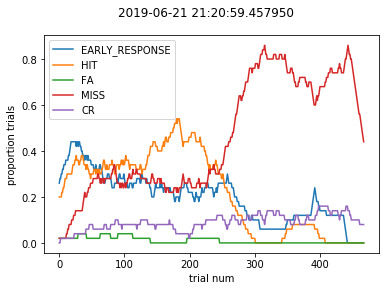

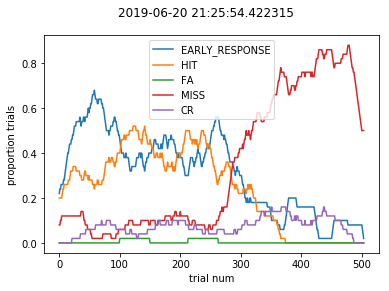

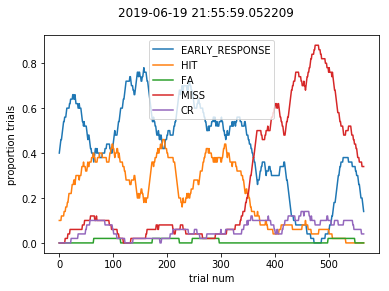

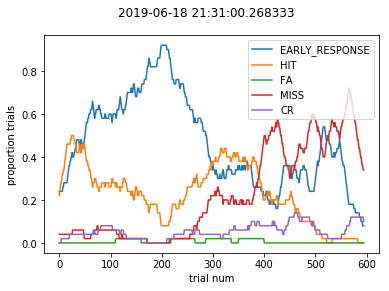

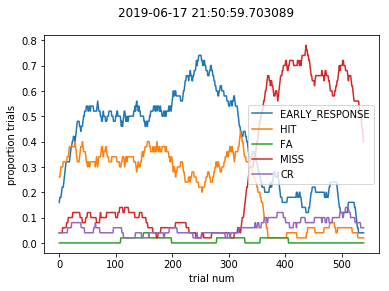

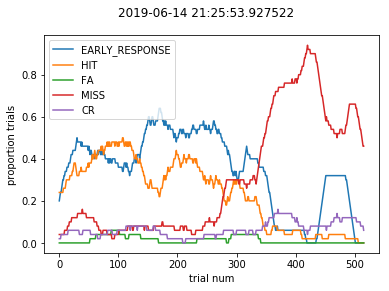

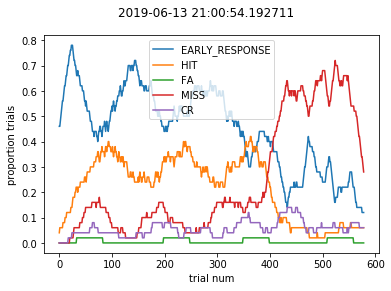

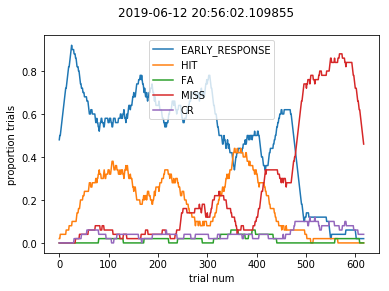

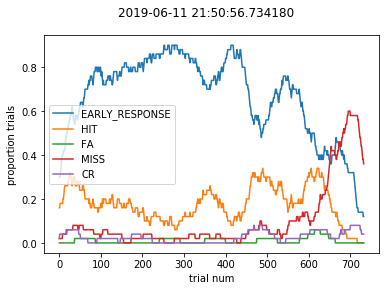

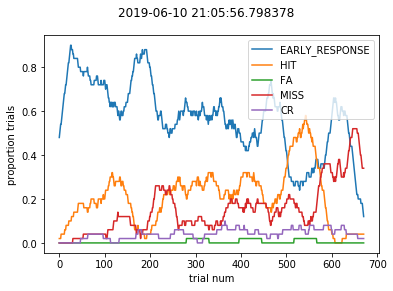

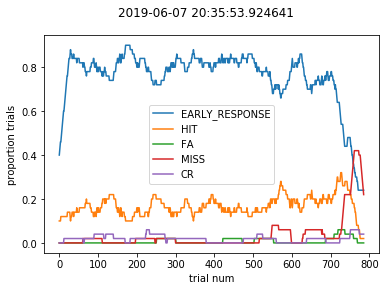

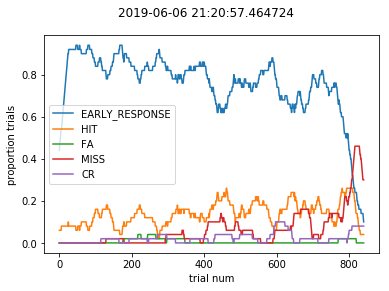

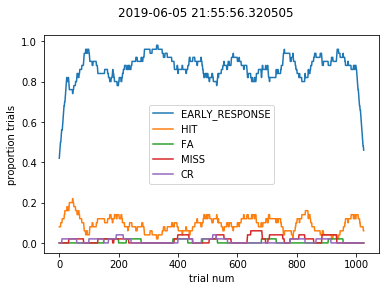

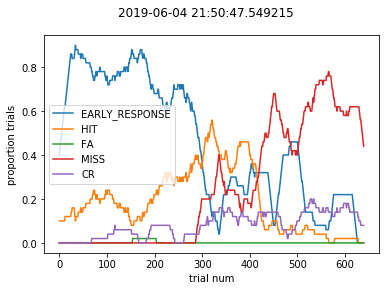

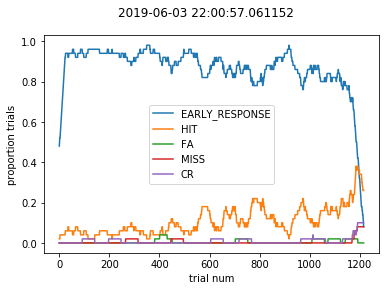

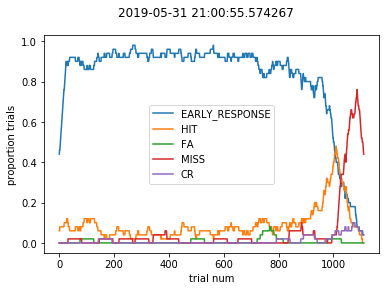

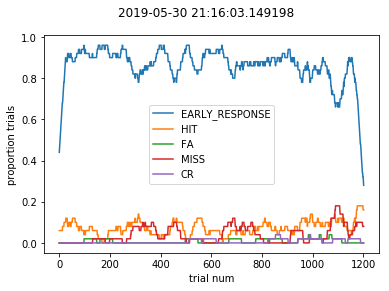

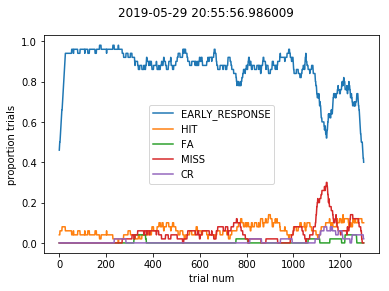

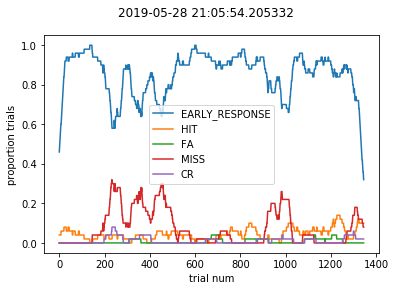

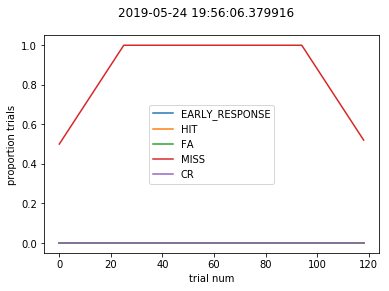

In [128]:
#plot proportion of trials that were aborts, hits and false alarms
for ir, row in toAnalyze.iterrows():
    fig, ax = plt.subplots()
    fig.suptitle(row['created_at'])
    [ax.plot(np.convolve(np.ones(50), row['trials']['response_type']==r, 'same')/50) for r in ['EARLY_RESPONSE', 'HIT', 'FA', 'MISS', 'CR']]
    ax.set_xlabel('trial num')
    ax.set_ylabel('proportion trials')
    ax.legend(['EARLY_RESPONSE', 'HIT', 'FA', 'MISS', 'CR'])
    

(array([737370.96597916, 737368.89650692, 737367.97987999, 737364.86181276,
        737363.81670359, 737362.7958271 , 737361.81667801, 737360.8271287 ,
        737356.83404982, 737355.86182602, 737354.85836447, 737353.85136117,
        737350.79579947, 737349.85484677, 737348.86877897, 737347.91040104,
        737346.9312056 ]), <a list of 17 Text xticklabel objects>)

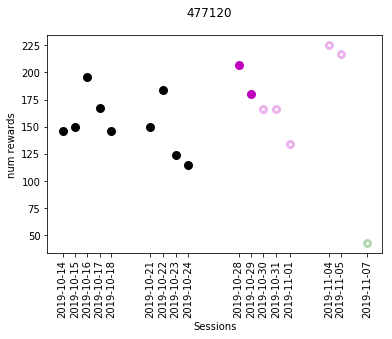

In [111]:
def getColorAlphaFill(row):
    a = 1.0
    f = 'full'
    if 'NP' not in row['rig']:
        c = 'k'
    elif 'TRAINING' in row['stage']:
        c = 'm'
    else:
        c = 'g'
    
    if 'low_volume' in row['stage']:
        a = 0.3
        f = 'none'
    return c,a,f

fig, ax = plt.subplots()
for ir, row in toAnalyze.iterrows():  
    num_rewards = row['trials']['cumulative_reward_number'].max()
    c,a,f = getColorAlphaFill(row)
    ax.plot(row['created_at'], num_rewards, c+'o', alpha=a, fillstyle=f, mew=3)
fig.suptitle(mouse_id)
ax.set_xlabel('Sessions')
ax.set_ylabel('num rewards')
ax.set_xticks([row['created_at'] for _,row in toAnalyze.iterrows()])
ax.set_xticklabels([row['created_at'].date() for _,row in toAnalyze.iterrows()])
plt.xticks(rotation=90)

In [145]:
toAnalyze['session_datetime_local'] = toAnalyze.apply(lambda row: pd.to_datetime(row['trials']['startdatetime'][0]), axis=1)
toAnalyze['session_datetime_utc'] = toAnalyze.apply(lambda row: pd.to_datetime(row['trials']['startdatetime'][0], utc=True), axis=1)

Text(0,0.5,u'Number of rewards earned')

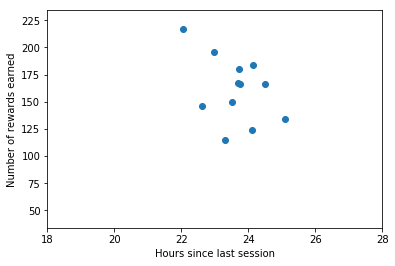

In [166]:
toAnalyze['cumulative_rewards'] = toAnalyze.apply(lambda row: row['trials']['cumulative_reward_number'].max(), axis=1)
toAnalyze['timeFromLastSession'] = toAnalyze['session_datetime_utc'].diff(periods=-1).astype('timedelta64[s]')/3600
fig, ax = plt.subplots()
ax.plot(toAnalyze['timeFromLastSession'], toAnalyze['cumulative_rewards'], 'o')
ax.set_xlim([18,28])
ax.set_xlabel('Hours since last session')
ax.set_ylabel('Number of rewards earned')

In [174]:
saveDir = r"C:\Users\svc_ccg\Desktop\Data\NP mouse behavior dfs"
toAnalyze.to_pickle(os.path.join(saveDir, str(mouse_id)+'_behavior.pkl'))